## Run & Tune XGBoost, Produce SHAP Visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler


### Data Import & Slice for City, Mode, Ablation Subsets

In [11]:
chi_df = pd.read_csv('/Users/mcott/Desktop/UMich/Milestone II/CHI_trunc.csv',dtype={1: str})
ny_df = pd.read_csv('/Users/mcott/Desktop/UMich/Milestone II/NYC_trunc.csv',dtype={1: str})

ny_df = ny_df.rename(columns={'mode_subway': 'mode_train'})

chi_bus_df =  chi_df[(chi_df['mode_train'] == False)].drop(columns=['mode'])
chi_train_df = chi_df[(chi_df['mode_train'] == True)]
ny_bus_df = ny_df[(ny_df['mode_train'] == False)]
ny_train_df = ny_df[(ny_df['mode_train'] == True)]

comb_df = pd.concat([chi_df,ny_df], ignore_index=True)
comb_df = comb_df.drop(columns=['mode'])

In [12]:
reduced_cols = ['is_weekend',
 'is_holiday',
 'is_holiday_adjacent', 
 'us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_max_lag',
 'apparent_temperature_min_lag',
 'relative_humidity_2m_mean',
 'rain_sum',
 'rain_max',
 'snow_any',
 'snow_heavy',
 'wind_speed_10m_mean',
 'wind_speed_10m_max',
 'wind_direction_10m_mean',
 'date',
 'mode_train',
 'daily_ridership']

reduced_chi_df = chi_df[reduced_cols]
reduced_chi_bus_df = reduced_chi_df[reduced_chi_df['mode_train'] == False]
reduced_chi_train_df = reduced_chi_df[reduced_chi_df['mode_train'] == True]

reduced_ny_df = ny_df[reduced_cols]
reduced_ny_bus_df = reduced_ny_df[reduced_ny_df['mode_train'] == False]
reduced_ny_train_df = reduced_ny_df[reduced_ny_df['mode_train'] == True]


In [13]:
ablation_cols = ['us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'apparent_temperature_max',
 'apparent_temperature_min',
 'apparent_temperature_max_lag',
 'apparent_temperature_min_lag',
 'relative_humidity_2m_mean',
 'rain_sum',
 'rain_max',
 'snow_any',
 'snow_heavy',
 'wind_speed_10m_mean',
 'wind_speed_10m_max',
 'wind_direction_10m_mean',
 'date',
 'mode_train',
 'daily_ridership']

ablation_df = comb_df[ablation_cols]

In [14]:
aqi_only_cols = ['us_aqi_mean',
 'us_aqi_pm2_5_mean',
 'us_aqi_pm10_mean',
 'us_aqi_nitrogen_dioxide_mean',
 'us_aqi_ozone_mean',
 'us_aqi_sulphur_dioxide_mean',
 'us_aqi_carbon_monoxide_mean',
 'date',
 'mode_train',
 'daily_ridership']

aqi_only_df = comb_df[aqi_only_cols]

### XGboost Testing & Results

In [24]:
def XGBoost(df):
    
    # Prepare data
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','mode_train'])
    y = df[target_col]

    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

    # Search for best parameters
    xgb = XGBRegressor(random_state=27, n_jobs=-1, tree_method='hist', verbosity=0)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [3, 5, 10],
        #'subsample': [0.8, 0.9, 1.0], - 0.9 shown to be best consistently in testing
        #'colsample_bytree': [0.8, 0.9, 1.0], - 0.9 shown to be best consistent in testing
        #'reg_alpha': [0, 0.5, 1], # - 0 always selected in testing
        'reg_lambda': [5, 10, 20],
    }

    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    xgb = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Cross-val scoring
    tscv = TimeSeriesSplit(n_splits=5)
    r2_scores = []
    rmse_scores = []

    for inner_train_idx, inner_val_idx in tscv.split(X_train, y_train):
        X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
        y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

        xgb.fit(X_inner_train, y_inner_train)
        y_val_pred = xgb.predict(X_inner_val)

        r2_scores.append(r2_score(y_inner_val, y_val_pred))
        rmse_scores.append(root_mean_squared_error(y_inner_val, y_val_pred))

    print("R² scores (CV):", r2_scores)
    print("RMSE scores (CV):", rmse_scores)
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    importances = xgb.feature_importances_
    feat_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(range(5), importances[sorted_idx[:5]])
    plt.yticks(range(5), feat_names[sorted_idx[:5]])
    plt.xlabel("Feature Importance")
    plt.title("Top 5 Important Features")
    plt.gca().invert_yaxis()
    plt.show()

    xgb.fit(X_train, y_train)
    y_pred_test = xgb.predict(X_test)
    print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
    print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")
    print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
    
    return xgb #, X_train, X_test, y_train, y_test

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 200, 'reg_lambda': 5}
R² scores (CV): [0.37157414373311937, -0.16124908985999298, 0.4688183103330672, -0.04561425776282779, -0.7397418085821235]
RMSE scores (CV): [386.17074513037414, 554.3785360987702, 546.4831630990793, 555.7401582503347, 513.1698864420937]
Mean R²: -0.0212 ± 0.4315
Mean RMSE: 511.19 ± 64.39


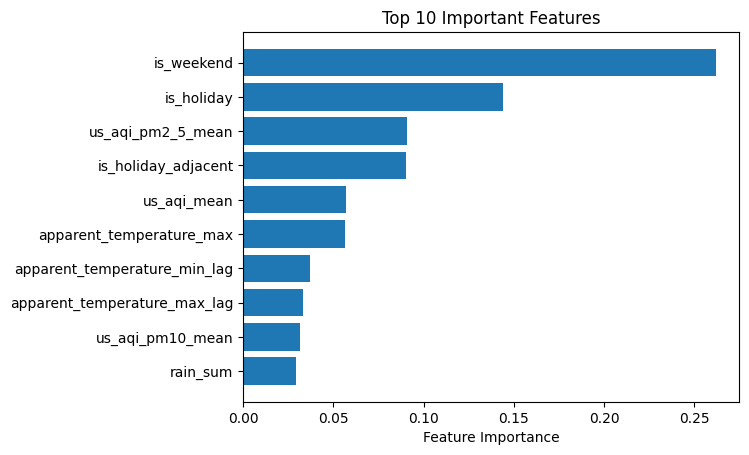

Test R²: 0.2584
Test RMSE: 631.95
Test MAE: 553.61


In [16]:
cb_xgb = XGBoost(reduced_chi_bus_df)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_lambda': 10}
R² scores (CV): [0.430667386375975, 0.085275133887171, 0.5014722943708834, 0.6382317663865285, 0.5918080877394196]
RMSE scores (CV): [321.7475377358572, 389.00968867971665, 390.92575223914866, 287.59240637639385, 267.08127978440325]
Mean R²: 0.4495 ± 0.1957
Mean RMSE: 331.27 ± 51.01


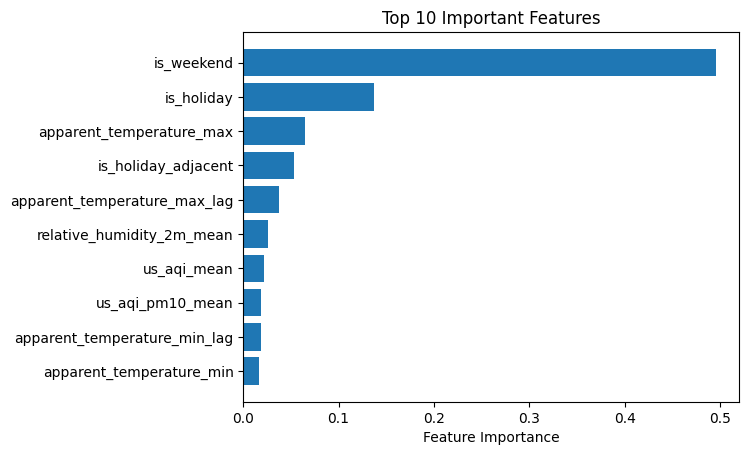

Test R²: 0.5973
Test RMSE: 331.71
Test MAE: 266.93


In [17]:
ct_xgb = XGBoost(reduced_chi_train_df)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 20}
R² scores (CV): [0.8110967922436638, 0.8573278943881003, 0.6557890800038635, 0.7550041402682031, 0.7938605838953353]
RMSE scores (CV): [329.8102410225591, 261.5438066040593, 434.07254173205, 327.88735433346056, 283.4767925877592]
Mean R²: 0.7746 ± 0.0679
Mean RMSE: 327.36 ± 59.42


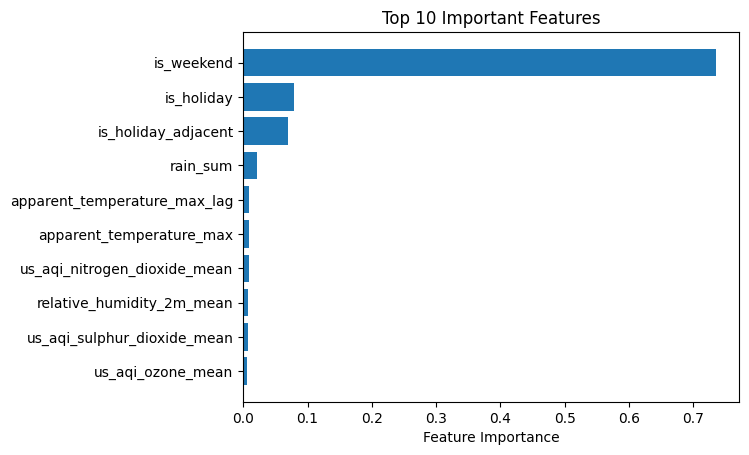

Test R²: 0.7800
Test RMSE: 354.61
Test MAE: 300.57


In [18]:
nb_xgb = XGBoost(reduced_ny_bus_df)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 10}
R² scores (CV): [0.7816946216879366, 0.8148986267061594, 0.7742434274311116, 0.8356379588256257, 0.8391240467856584]
RMSE scores (CV): [838.6214079457691, 749.2124788005483, 939.1094585436615, 747.7114889100357, 716.4425690005249]
Mean R²: 0.8091 ± 0.0269
Mean RMSE: 798.22 ± 81.39


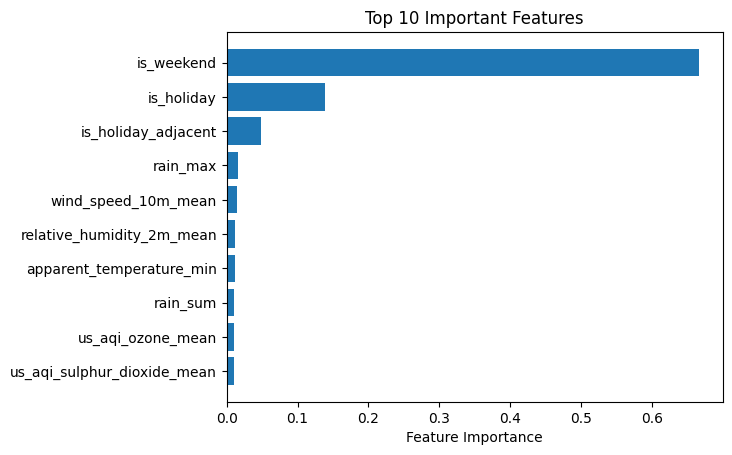

Test R²: 0.6920
Test RMSE: 1095.47
Test MAE: 924.56


In [20]:
nt_xgb = XGBoost(reduced_ny_train_df)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'reg_lambda': 10}
R² scores (CV): [0.0892196307761236, 0.01795653318508139, -0.08769095858099751, 0.11628768659056743, 0.18665961362357308]
RMSE scores (CV): [1077.280988837777, 1194.5440813258554, 1913.8196004627828, 2461.6641565750665, 2581.0552722488737]
Mean R²: 0.0645 ± 0.0933
Mean RMSE: 1845.67 ± 622.78


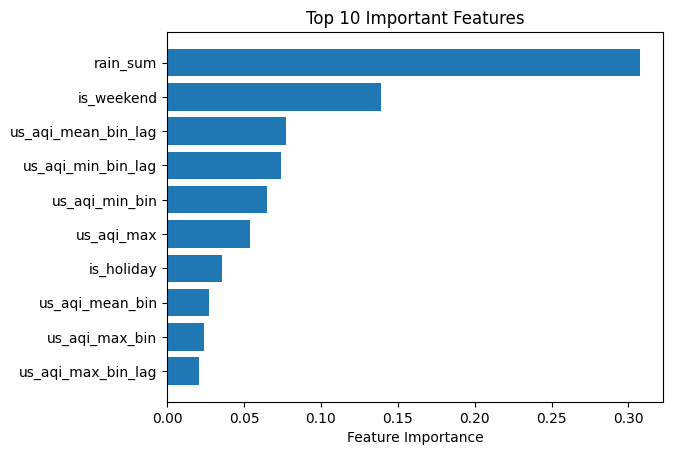

Test R²: 0.1405
Test RMSE: 2727.03
Test MAE: 2582.74


In [21]:
all_xgb = XGBoost(comb_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'reg_lambda': 20}
R² scores (CV): [-0.0396630266774074, -0.056274740134027335, -0.1680524409384363, -0.19560649599662616, -0.09377908566767545]
RMSE scores (CV): [1150.981822487906, 1238.8686767676068, 1983.2588892562576, 2863.3041445558774, 2993.1325059609817]
Mean R²: -0.1107 ± 0.0613
Mean RMSE: 2045.91 ± 777.37


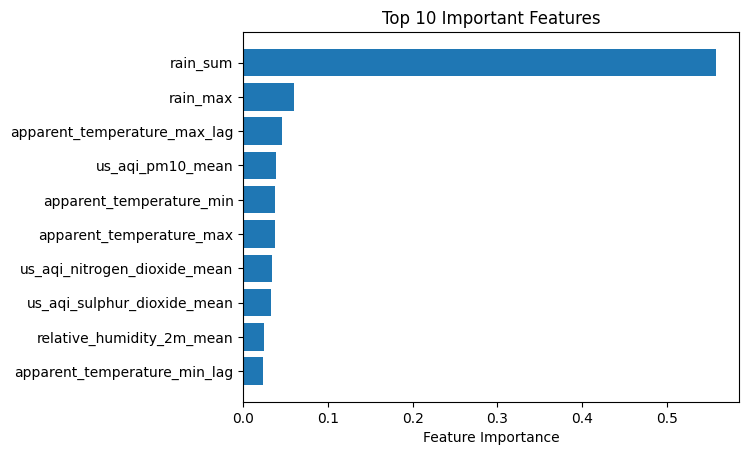

Test R²: -0.0861
Test RMSE: 3065.59
Test MAE: 2607.80


In [22]:
abla_xgb = XGBoost(ablation_df)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 5}
R² scores (CV): [-0.06704183573112243, -0.07953685358496321, -0.1584571748978829, -0.599979752050352, -0.34488897517496087]
RMSE scores (CV): [1166.0384962603036, 1252.436056086794, 1975.096096712362, 3312.307074834545, 3318.977840068623]
Mean R²: -0.2500 ± 0.2012
Mean RMSE: 2204.97 ± 949.39


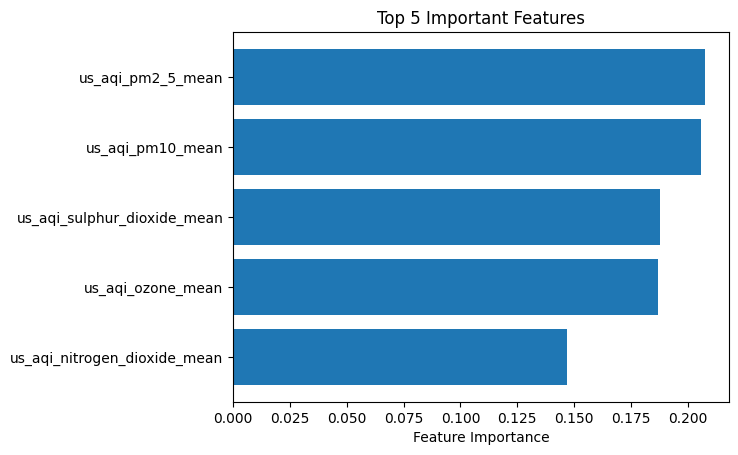

Test R²: -0.2545
Test RMSE: 3294.69
Test MAE: 2576.99


In [25]:
aqi_xgb = XGBoost(aqi_only_df)

### XGboost Visualizations - Input Top Hyperparameters

In [82]:
def XGBoost_SHAP(df,i=0):
    
    # Prepare data
    target_col = 'daily_ridership'
    X = df.drop(columns=[target_col,'date','mode_train'])
    y = df[target_col]
    
    # Split data
    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]
    
    # Train XGBoost model
    model = XGBRegressor(
        n_estimators = 150,
        max_depth = 20,
        learning_rate = 0.1,
        subsample = 0.9,
        colsample_bytree = 0.9,
        reg_alpha = 0.1,
        reg_lambda = 1,
        random_state = 27,
        n_jobs = -1,
        tree_method='hist',
        eval_metric='rmse')
    model.fit(X_train, y_train)

    # Get predictions - use for waterfalls of largest errors
    y_pred_test = model.predict(X_test)
    errors = np.abs(y_test.values - y_pred_test)

    # adjust the row index on this to evaluate additional waterfall plots 
    worst_errors = np.argsort(errors)[::-1]
    worst_index = worst_errors[i]

    df_test = df.iloc[-test_size:].reset_index(drop=True)
    original_row = df_test.iloc[worst_index]

    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # SHAP values
    explainer = shap.Explainer(model, X_train, seed=27)
    shap_values = explainer(X_test)

    # SHAP Waterfall plot example (only shows feature importance for the i-th worst prediction)
    plt.figure(figsize=(10, 8))
    shap.plots.waterfall(shap_values[worst_index],show=False)
    plt.title(
                 f"Date: {original_row['date']}\n" +
                 f"Actual: {y_test.iloc[worst_index]:.0f} | Predicted: {y_pred_test[worst_index]:.0f} | Error: {errors[worst_index]:.0f}")
    plt.tight_layout()
    plt.show()

    # Create SHAP Beeswarm plot (similar to summary plot, better performance with large datasets)
    '''
    plt.figure(figsize=(10, 8))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title('SHAP Beeswarm Plot - Feature Importance')
    plt.tight_layout()
    plt.show()
    '''

    # SHAP force plot example (only shows feature importance for a single prediction)
    '''
    shap.force_plot(explainer.expected_value,shap_values[0], X_test.iloc[0, :], matplotlib=True)
    '''

 98%|===================| 572/584 [00:18<00:00]        

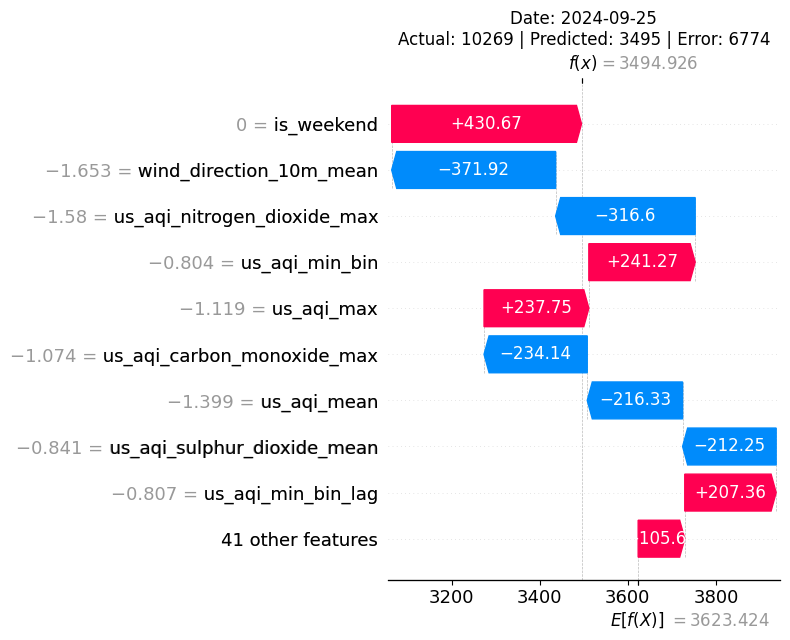

In [83]:
XGBoost_SHAP(comb_df,0)


 98%|===================| 575/584 [00:17<00:00]        

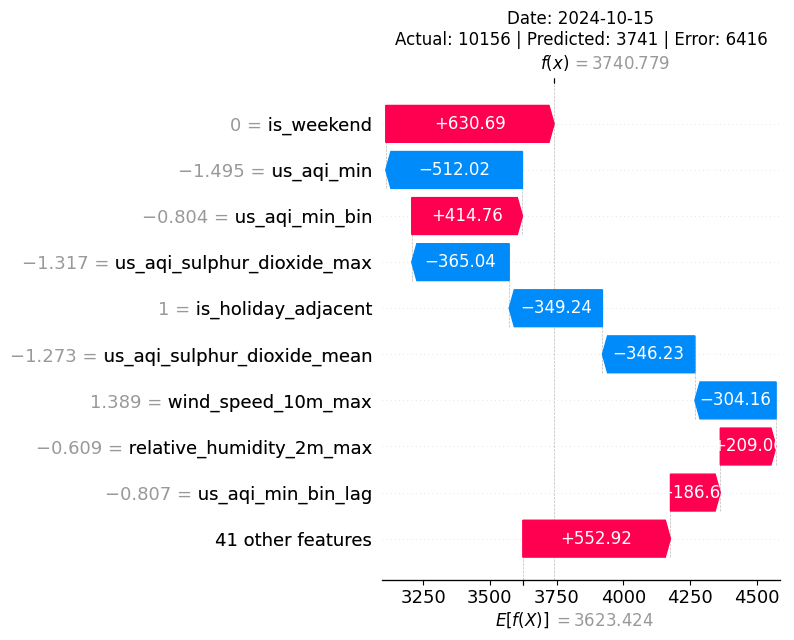

In [87]:
XGBoost_SHAP(comb_df,1)

 98%|===================| 572/584 [00:17<00:00]        

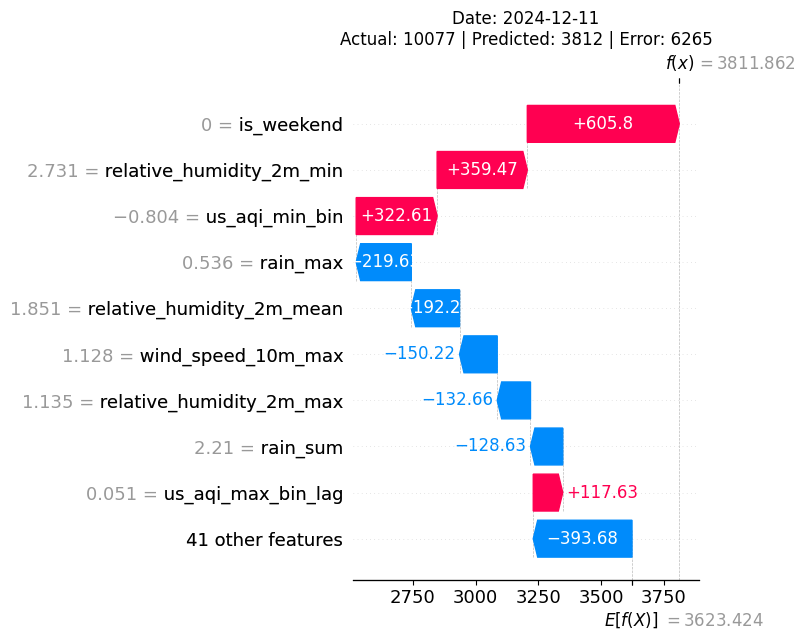

In [88]:
XGBoost_SHAP(comb_df,2)